In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style='whitegrid')
# For modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load Data
Data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club?datasetId=902). Information about the columns can be seen here on [google drive](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view).

In [2]:
accepted_df = pd.read_csv(filepath_or_buffer="../data/raw/accepted_2007_to_2018Q4.csv")
#rejected_df = pd.read_csv(filepath_or_buffer="data/raw/rejected_2007_to_2018Q4.csv")

/var/folders/h0/sqy12xn11_gg038734m010lh0000gn/T/ipykernel_70475/4258043331.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv(filepath_or_buffer="data/raw/accepted_2007_to_2018Q4.csv")


In [3]:
# Take on subset of the whole data to better work with it
# TODO: Delete this later for the final fit of our model(s)
# Attention: For NaNs Identification etc... use full dataset
n_sample = 50000
accepted_df = accepted_df.sample(n=n_sample)
#rejected_df = rejected_df.sample(n=n_sample)

In [4]:
# Get number of rows apriori of preprocessing
N = accepted_df.shape[0]

# Print information about raw datasets
print(f"Shape of accepted_df: {accepted_df.shape}")
#print(f"Shape of rejected_df: {rejected_df.shape}")

Shape of accepted_df: (50000, 151)


In [5]:
accepted_df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2011278,85574541,NaN,23475.0,23475.0,23475.0,36 months,16.99,836.84,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1068080,71025301,NaN,24000.0,24000.0,23950.0,60 months,18.99,622.45,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2001235,85749258,NaN,8000.0,8000.0,8000.0,36 months,9.49,256.23,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
735830,76698297,NaN,23000.0,23000.0,23000.0,60 months,14.46,540.68,C,C4,...,NaN,NaN,Cash,Y,Mar-2018,ACTIVE,Mar-2018,9310.0,50.0,14.0
1749485,96489808,NaN,9900.0,9900.0,9900.0,36 months,11.49,326.42,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
In this section we remove features that contain too many NaNs and which are also not (or less) relevant for our prediction.

In [6]:
# Compute fraction of NaNs in each Attribute
null_count_series = accepted_df.isna().sum().div(N)
# Sort descending
null_count_series = null_count_series.sort_values(ascending=False)

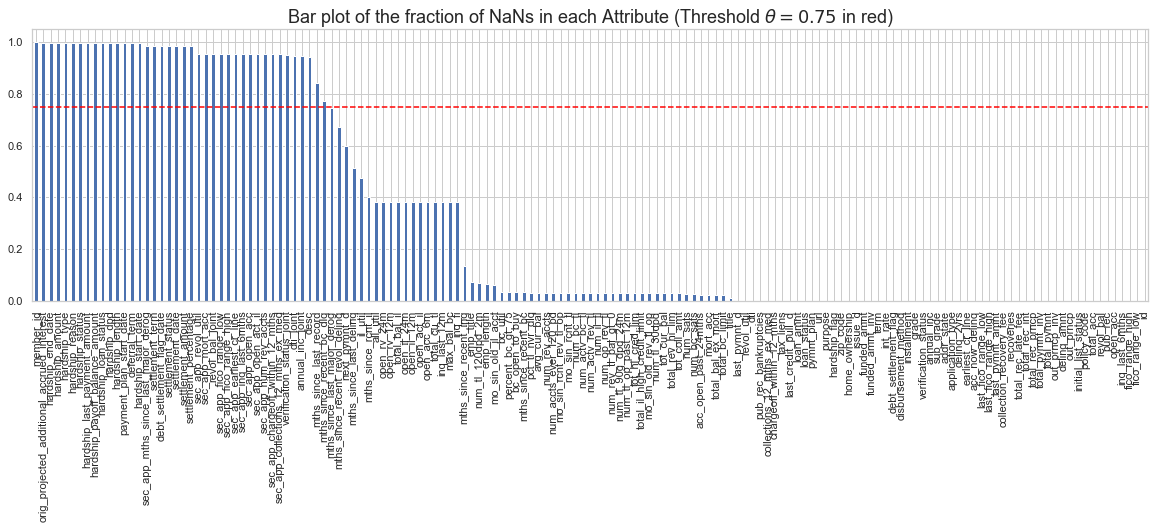

In [7]:
# Define threshold theta: Each column with more or equal NaNs than the threshold will be removed.
threshold = 0.75

plt.figure(figsize=(20,5))
plt.title(f"Bar plot of the fraction of NaNs in each Attribute (Threshold $\\theta = {threshold}$ in red)", size=18)
null_count_series.plot.bar()
# Add threshold as red line
plt.axhline(y=threshold, color="red", linestyle = "--")
plt.show()

In [8]:
# Remove all rows where the NaN Fraction is >= threshold.
null_count_series_cut = null_count_series[null_count_series.values < threshold]

In [9]:
# Get column names of the features with NaN fraction < threshold
columns_post_nan_cut = list(null_count_series_cut.index)
# Keep all columns in accepted_df that are in columns_post_nan_cut
accepted_df = accepted_df.drop([col for col in accepted_df.columns if col not in columns_post_nan_cut], axis=1)

In [10]:
accepted_df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
2011278,85574541,23475.0,23475.0,23475.0,36 months,16.99,836.84,D,D1,Admin Research Coordinator,...,100.0,0.0,0.0,13300.0,13125.0,13300.0,0.0,N,Cash,N
1068080,71025301,24000.0,24000.0,23950.0,60 months,18.99,622.45,D,D4,Project Manager,...,50.0,0.0,0.0,345147.0,64794.0,23000.0,35522.0,N,Cash,N
2001235,85749258,8000.0,8000.0,8000.0,36 months,9.49,256.23,B,B2,Manager of Technology,...,33.3,0.0,0.0,27900.0,15732.0,11900.0,14500.0,N,Cash,N
735830,76698297,23000.0,23000.0,23000.0,60 months,14.46,540.68,C,C4,General Manager,...,33.3,0.0,0.0,65936.0,38625.0,12300.0,41950.0,N,Cash,Y
1749485,96489808,9900.0,9900.0,9900.0,36 months,11.49,326.42,B,B5,Welder,...,0.0,0.0,0.0,47440.0,34946.0,8500.0,31240.0,N,Cash,N


## Feature Selection based on Description
In this section we remove irrelevant features based on the official details list. For example, the attributes containing dates add no (or less) information for our model(s). Also columns like the 'url' are not relevant. 'emp_title', i.e. job title has too many different categorical values.

TODO: Do Feature Selection BEFORE NaNs Removal

In [11]:
# Define irrelevant columns to drop, also includes columns like 'id' which we cannot use for prediction
irrelevant_columns = ['url', 'zip_code', 'id', 'emp_title', 'issue_d', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'disbursement_method', 'debt_settlement_flag', 'hardship_flag']

accepted_df.drop(irrelevant_columns, axis=1, inplace=True)

In [12]:
# Feature Cleaning

def clean_employment_length(value:str):
    """
    Function to clean and encode the attribute "emp_length"
    :param value: Content of the cell
    :return: Cleaned encoding, i.e. 0 for <1 year, and 10 for more than 10 years employment.
    """
    if value == "< 1 year":
        return 0
    if value == "10+ years":
        return 10
    if value == np.NaN:
        return np.NaN
    # For the rest, i.e. values of the form "x years" -- keep only the numeric value
    return re.sub('[^0-9]','', str(value))

# Remove "years" in "emp_length" and encode values according to the function defined above
accepted_df['emp_length'] = accepted_df['emp_length'].apply(lambda x: clean_employment_length(x))
# Remove suffix in attribute "term"
accepted_df["term"] = accepted_df["term"].apply(lambda x: re.sub('[^0-9]','', str(x)))

In [13]:
accepted_df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
2011278,23475.0,23475.0,23475.0,36,16.99,836.84,D,D1,2,RENT,...,0.0,0.0,100.0,100.0,0.0,0.0,13300.0,13125.0,13300.0,0.0
1068080,24000.0,24000.0,23950.0,60,18.99,622.45,D,D4,5,MORTGAGE,...,0.0,4.0,94.0,50.0,0.0,0.0,345147.0,64794.0,23000.0,35522.0
2001235,8000.0,8000.0,8000.0,36,9.49,256.23,B,B2,5,RENT,...,0.0,1.0,93.7,33.3,0.0,0.0,27900.0,15732.0,11900.0,14500.0
735830,23000.0,23000.0,23000.0,60,14.46,540.68,C,C4,5,RENT,...,0.0,1.0,100.0,33.3,0.0,0.0,65936.0,38625.0,12300.0,41950.0
1749485,9900.0,9900.0,9900.0,36,11.49,326.42,B,B5,2,RENT,...,0.0,1.0,100.0,0.0,0.0,0.0,47440.0,34946.0,8500.0,31240.0
613956,1200.0,1200.0,1200.0,36,11.99,39.86,B,B5,3,MORTGAGE,...,0.0,2.0,100.0,0.0,1.0,0.0,134958.0,26974.0,12500.0,27053.0
1256666,20000.0,20000.0,19975.0,36,8.39,630.34,A,A5,10,MORTGAGE,...,0.0,2.0,100.0,0.0,0.0,0.0,376970.0,162069.0,45000.0,140870.0
198771,20000.0,20000.0,20000.0,36,13.99,683.46,C,C4,,MORTGAGE,...,0.0,0.0,100.0,50.0,0.0,0.0,277700.0,33715.0,44600.0,0.0
2202505,6400.0,6400.0,6400.0,36,24.74,253.59,E,E3,10,RENT,...,0.0,5.0,100.0,100.0,0.0,0.0,59598.0,47931.0,15800.0,30198.0
737701,30000.0,30000.0,30000.0,36,12.99,1010.68,C,C2,10,MORTGAGE,...,1.0,1.0,86.4,25.0,0.0,0.0,134322.0,100829.0,25500.0,95522.0


In [44]:
# TODO: Encode categorical values to numeric ones, e.g. with One Hot Encoder
accepted_df.dtypes

#sns.histplot(accepted_df.dtypes.values)
print(accepted_df.dtypes.value_counts())
# Show columns where its type != float64
print(accepted_df.dtypes[accepted_df.dtypes != "float64"])

float64    86
object      8
dtype: int64
term                   object
grade                  object
sub_grade              object
emp_length             object
home_ownership         object
verification_status    object
loan_status            object
application_type       object
dtype: object
